## Time Series Mini Project

In [1]:
# imports
import pandas as pd
import requests
import acquire
import prepare
import project
import matplotlib.pyplot as plt
import seaborn as sns
from time import strftime

### Assignment
The goal of this mini-project is to practice what you have learned at each stage of the pipeline throughout the time series module. You will use the earth surface temperature data offered by Berkeley Earth through Kaggle.com. You will select one location, could be a city or a state or something relatively similar in size and analyze the patterns in temperature over time. You will then model those patterns to forecast temperature into the future (how far is up to you, but should be something meaningful).



Use the data from this kaggle competition: https://www.kaggle.com/berkeleyearth/climate-change-earth-surface-temperature-data

There will not be a presentation, but be sure and have a final notebook that someone could quickly review to see what you found. Don't forget the planning stage! Practice all the techniques and best practices you have been taught and have been using in each module thus far. 

Create a notebook within your existing time series exercises repository.

Submit a link to your final notebook.

### Project Planning
1. Pick a city / state from data set
2. Acquire the data
3. Explore the unclean data to determine Data Prep Need To
4. Prepare / clean / tidy the data for splitting / exploration
5. Pick a reasonable splitting point and split into train / test datasets
6. Explore the train dataset
    - Look at Daily / Weekly / Monthly / Quarterly / Yearly trends / cycles
    - Visualize changes over time
    - Visualize a seasonal cycle
    - Show lag plots / Auto-correlation / Decomposition / Mas
7. Build at least 3 Models (Simple Average, Moving Average, Holt's Linear Trend, Change timeframe based-on)
8. Evaluate Models, adjust hyperparameters and pick best model to evaluate on test
9. Conclusions / Takeaways / Next Steps

### Data Wrangling
#### Goals:
- Bring in Data for Raleigh, NC
- Convert 'dt' column to DateTime, and reset to Index
- Drop null values
- drop unneccessary columns
- rename columns for ease of use
- return a clean pandas DataFrame ready for exploration

In [2]:
df = project.get_raleigh()

In [3]:
df = project.initial_prep(df, 'dt')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1365 entries, 1900-01-01 to 2013-09-01
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   avg_temp              1365 non-null   float64
 1   avg_temp_uncertainty  1365 non-null   float64
dtypes: float64(2)
memory usage: 32.0 KB


In [5]:
df.head()

,avg_temp,avg_temp_uncertainty
dt,,
1900-01-01,3.569,0.504
1900-02-01,2.909,0.813
1900-03-01,7.374,0.459
1900-04-01,13.868,0.445
1900-05-01,19.408,0.572


In [6]:
df.describe()

,avg_temp,avg_temp_uncertainty
count,1365.000000,1365.000000
mean,14.722171,0.298994
std,7.912140,0.121169
min,-2.690000,0.062000
25%,7.672000,0.215000
50%,14.759000,0.280000
75%,22.512000,0.353000
max,28.089000,0.943000


In [7]:
df.index.min(), df.index.max()

(Timestamp('1900-01-01 00:00:00'), Timestamp('2013-09-01 00:00:00'))

In [10]:
df.index.nunique()

1365

In [8]:
df = project.add_month_col(df)

In [11]:
df.head(1092)

,avg_temp,avg_temp_uncertainty,month
dt,,,
1900-01-01,3.569,0.504,01-Jan
1900-02-01,2.909,0.813,02-Feb
1900-03-01,7.374,0.459,03-Mar
1900-04-01,13.868,0.445,04-Apr
1900-05-01,19.408,0.572,05-May
...,...,...,...
1990-08-01,25.153,0.235,08-Aug
1990-09-01,21.496,0.227,09-Sep
1990-10-01,16.414,0.289,10-Oct


In [12]:
# Let's split into train and test
# we will use the 80-20 method (roughly)

train = df.loc[:'1990']
test = df.loc['1991':]

In [13]:
# did I lose any data?
train.shape, test.shape

((1092, 3), (273, 3))

In [14]:
train.index.min(), train.index.max()

(Timestamp('1900-01-01 00:00:00'), Timestamp('1990-12-01 00:00:00'))

In [15]:
test.index.min(), test.index.max()

(Timestamp('1991-01-01 00:00:00'), Timestamp('2013-09-01 00:00:00'))

#### Data Wrangling Takeaways:
- I now have a clean dataset of 3119 observations
- from 1743 to 2013
- A small percentage of months are missing, but it shouldn't impact results
- The train set has 2498 observations from 1743 to 1961
- The test set has 621 observations from 1962 to 2013

### Data Exploration
#### Goals:
- Visualize the data in different ways to look for:
    - Overall trend
    - Seasonal trends
    - Unique observations
- 
    

In [16]:
df = project.add_month_col(df)

In [17]:
# set a target variable to plot / explore
y = train['avg_temp']

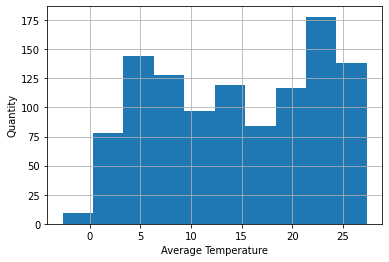

In [18]:
y.hist()
plt.xlabel('Average Temperature')
plt.ylabel('Quantity')
plt.show()

#### Histogram Takeaways:
- Clear bimodality suggesting two distinct curves to complete one season
- Appears to be a slightly wider spread of colder temperatures

<AxesSubplot:xlabel='dt'>

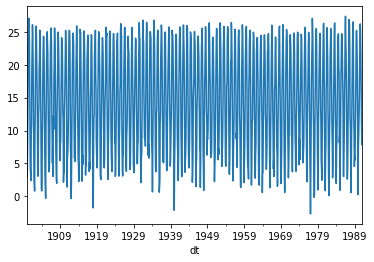

In [19]:
# what does it look like over time, as is?
y.plot()

<AxesSubplot:xlabel='dt'>

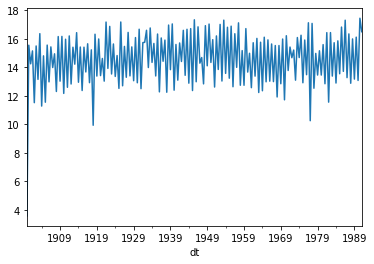

In [20]:
y.resample('6M').mean().plot()

<AxesSubplot:xlabel='dt'>

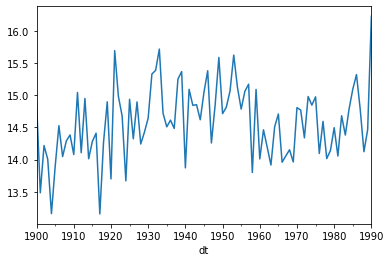

In [21]:
y.resample('Y').mean().plot()

<AxesSubplot:xlabel='dt'>

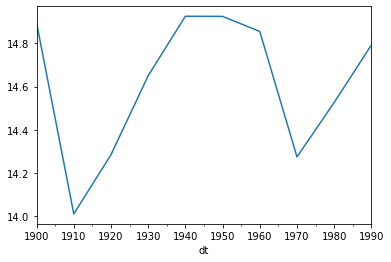

In [22]:
y.resample('10Y').mean().plot()

<AxesSubplot:xlabel='month'>

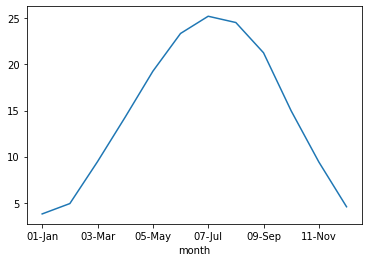

In [23]:
train.groupby('month').mean().avg_temp.plot()

<AxesSubplot:ylabel='dt'>

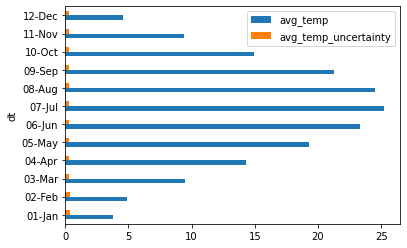

In [24]:
train.groupby(train.index.strftime('%m-%b')).mean().plot.barh()